# Importando bibliotecas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Funções

In [3]:
def concatenar_parcial(df,ano):
    meses = df.columns[1:]
    dataframes = []
    for mes in meses:
        df_aux = df[mes]
        df_aux = df_aux.iloc[:-2]
        if mes in ['Abr', 'Jun', 'Set', 'Nov']:
            df_aux = df_aux.iloc[:-1]
        elif mes == 'Fev':
            if ano in [2012,2016,2020,2024]:
                df_aux = df_aux.iloc[:-2]
            else:
                df_aux = df_aux.iloc[:-3]

                
        if df_aux.isnull().all():
            break
        dataframes.append(df_aux)

    df_resultante = pd.concat(dataframes, ignore_index=True)
    return df_resultante



# Extraíndo dados

In [4]:
import pandas as pd
anos = 14
dataframe = []
for ano in range(2010,2010+anos+1):
    caminho_arquivo = f'ibovespa/{ano}.csv'

    df = pd.read_csv(caminho_arquivo, sep=';', decimal='.', header=1,encoding='latin-1')
    dataframe.append(concatenar_parcial(df,ano))
df_resultante = pd.concat(dataframe, ignore_index=True)


date_range = pd.date_range(start='2010-01-01', periods=len(df_resultante), freq='D')
df_resultante.index = date_range
df_resultante = df_resultante.iloc[:-30]

df = pd.DataFrame({'valor': df_resultante})
df['valor'] = df['valor'].str.replace(',', '')
df['valor'] = df['valor'].astype(float)
df['data'] = df.index

In [5]:
df

,valor,data
2010-01-01,NaN,2010-01-01
2010-01-02,NaN,2010-01-02
2010-01-03,NaN,2010-01-03
2010-01-04,70.04508,2010-01-04
2010-01-05,70.23982,2010-01-05
...,...,...
2024-05-27,124.49568,2024-05-27
2024-05-28,123.77954,2024-05-28
2024-05-29,122.70728,2024-05-29
2024-05-30,NaN,2024-05-30


# Tratando dados

In [6]:

datas = pd.DataFrame(df.index)
df = df.assign(data=df.index)
df.head()

,valor,data
2010-01-01,NaN,2010-01-01
2010-01-02,NaN,2010-01-02
2010-01-03,NaN,2010-01-03
2010-01-04,70.04508,2010-01-04
2010-01-05,70.23982,2010-01-05


# Separando dados de treino teste e previsão

In [7]:
treino = df[df.index < '2021-03-15']
teste = df[(df.index >= '2021-03-15') & (df.index < '2023-12-31')]
previsao = df[df.index >= '2023-12-31']

In [8]:
len(treino)/(len(treino)+len(teste))

0.8002738654147105

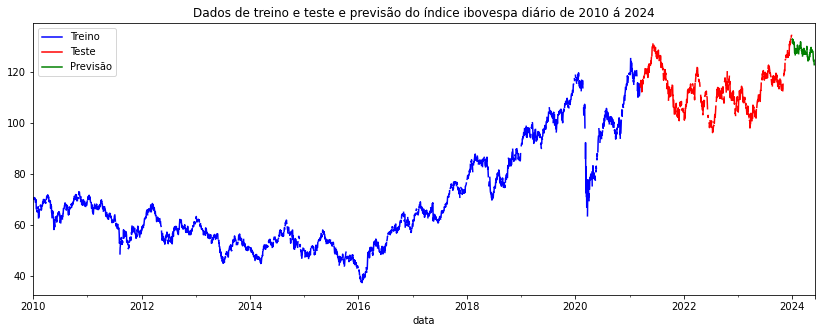

In [9]:
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
treino.plot(kind='line', x='data', y='valor', color='blue', label='Treino', ax=ax)
teste.plot(kind='line', x='data', y='valor', color='red', label='Teste', ax=ax)
previsao.plot(kind='line', x='data', y='valor', color='green', label='Previsão', ax=ax)
plt.title('Dados de treino e teste e previsão do índice ibovespa diário de 2010 á 2024')
plt.show()

In [10]:
datas

,0
0,2010-01-01
1,2010-01-02
2,2010-01-03
3,2010-01-04
4,2010-01-05
...,...
5260,2024-05-27
5261,2024-05-28
5262,2024-05-29
5263,2024-05-30


In [11]:
treino.to_csv('dados_tratados/treino.csv', header=True, index=False)
teste.to_csv('dados_tratados/teste.csv', header=True, index=False)
previsao.to_csv('dados_tratados/previsao.csv', header=True, index=False)
datas.to_csv('dados_tratados/datas.csv', header=True, index=False)

In [12]:
def df_tratamento_dados(df):
    df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
    df = df.sort_values(by='data')
    # Completando dados
    # Crie um novo DataFrame com um intervalo completo de datas
    data_inicio = df['data'].min()  # Data de início
    data_fim = df['data'].max()  
    datas_completas = pd.date_range(start=data_inicio, end=data_fim, freq='D')
    # Crie um novo DataFrame com o intervalo completo de datas
    df_completo = pd.DataFrame(datas_completas, columns=['data'])# Faça um merge com o dataframe original

    df = df_completo.merge(df, on='data', how='left')
    df = df.sort_values(by='data')

    
    df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
    df.index = pd.to_datetime(df['data'])
    # Interpolação linear
    df['valor'] = df['valor'].interpolate(method='linear')
    df['valor'] = df['valor'].fillna(method='bfill')
    df.sort_index(ascending=True, inplace=True)
    df = df.asfreq('D')
    return df

In [14]:
def ler_csv(caminho_arquivo):
    return pd.read_csv(caminho_arquivo, sep=',',usecols=[0,1], decimal=',', header=0)

treino = ler_csv('dados_tratados/treino.csv')
teste = ler_csv('dados_tratados/teste.csv')
previsao = ler_csv('dados_tratados/previsao.csv')

In [15]:
treino = df_tratamento_dados(treino)
teste = df_tratamento_dados(teste)
previsao = df_tratamento_dados(previsao)

In [16]:
total = pd.concat([treino,teste,previsao])

In [18]:
total

,data,valor
data,,
2010-01-01,2010-01-01,70.045080
2010-01-02,2010-01-02,70.045080
2010-01-03,2010-01-03,70.045080
2010-01-04,2010-01-04,70.045080
2010-01-05,2010-01-05,70.239820
...,...,...
2024-05-27,2024-05-27,124.495680
2024-05-28,2024-05-28,123.779540
2024-05-29,2024-05-29,122.707280


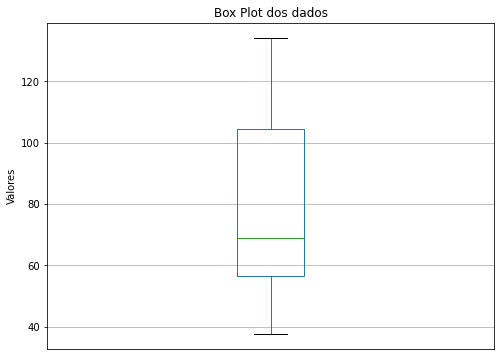

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

total.boxplot(column=['valor'], grid=True, figsize=(8, 6))
plt.title("Box Plot dos dados")
plt.ylabel("Valores")
plt.xticks([])  # Remova os rótulos do eixo x
plt.show()


In [26]:
import pandas as pd

# Suponha que você já tenha um DataFrame chamado 'total' com a coluna 'valor'

# Contagem
total_count = total['valor'].count()

# Média
total_mean = total['valor'].mean()

# Desvio Padrão
total_std = total['valor'].std()

# Coeficiente de Variação
cv = (total_std / total_mean) * 100

# Mínimo e Máximo
valor_min = total['valor'].min()
valor_max = total['valor'].max()

# Quartis (25%, 50%, 75%)
q25 = total['valor'].quantile(0.25)
q50 = total['valor'].quantile(0.50)  # Equivalente à mediana
q75 = total['valor'].quantile(0.75)

# Imprimir os resultados
print(f"Contagem: {total_count}")
print(f"Média: {total_mean}")
print(f"Desvio Padrão: {total_std}")
print(f"Coeficiente de Variação: {cv:.2f}%")
print(f"Mínimo: {valor_min}")
print(f"Máximo: {valor_max}")
print(f"Quartis (25%, 50%, 75%): {q25}, {q50}, {q75}")


Contagem: 5265
Média: 79.13773200000014
Desvio Padrão: 26.15303811527205
Coeficiente de Variação: 33.05%
Mínimo: 37.49747
Máximo: 134.19372
Quartis (25%, 50%, 75%): 56.53162, 68.95242, 104.38467
